# Advanced Visualizations

## Set-Up

In [11]:
using DrWatson
@quickactivate "CategoricalDataScience"

In [12]:
using CairoMakie
using CSV
using GeoMakie
using Polylabel
using DataFrames
using GeoDataFrames
using Distributions
using StatsBase
using Statistics
using SwarmMakie
using ZipFile
using Shapefile

In [13]:
states_of_interest = ["Wisconsin",
    "Michigan",
    "Illinois",
    "Indiana",
    "Ohio",
    "Kentucky",
    "Tennessee",
    "Pennsylvania",
    "West Virginia",
    "New York",
]

10-element Vector{String}:
 "Wisconsin"
 "Michigan"
 "Illinois"
 "Indiana"
 "Ohio"
 "Kentucky"
 "Tennessee"
 "Pennsylvania"
 "West Virginia"
 "New York"

In [ ]:
country = DataFrame()
for filename in readdir(joinpath("..", "..", "data", "exp_raw", "arda"))
    state_name = titlecase(splitext(split(filename, "state_")[2])[1])
    println("Processing $state_name")
    df = CSV.read(
        joinpath("..", "..", "data", "exp_raw", "arda", filename),
        DataFrame,
        types=Dict(
            "Adherents" => Union{Missing, Int32},
            "Congregations" => Union{Missing, Int32},
            "Religious Bodies" => String),
        silencewarnings=true) |> DataFrame
    df = df[completecases(df, ["Religious Bodies", "Tradition", "Family"]), :]
    df = df[(strip.(df[:, "Religious Bodies"])) .|> x -> !isempty(x), :]
    df = coalesce.(df, 0)
    df = groupby(df, [:Tradition]) # groupby the tradition
    df = combine(
        df,
        [:Adherents, :Congregations] =>
        ((a, c) -> (Adherents=sum(a), Congregations=sum(c))) =>
        AsTable) # add adherents and congregation when we do the groupby
    df.State .= state_name # add a feature that says which state the data is from
    country = vcat(country, df) # concatenate this into a larger dataframe
end


Processing Alabama
Processing Alaska
Processing Arizona
Processing Arkansas
Processing California
Processing Colorado
Processing Connecticut
Processing Delaware
Processing District Of Columbia
Processing Florida
Processing Georgia
Processing Hawaii
Processing Idaho
Processing Illinois
Processing Indiana
Processing Iowa
Processing Kansas
Processing Kentucky
Processing Louisiana
Processing Maine
Processing Maryland
Processing Massachusetts
Processing Michigan
Processing Minnesota
Processing Mississippi
Processing Missouri
Processing Montana
Processing Nebraska
Processing Nevada
Processing New Hampshire
Processing New Jersey
Processing New Mexico
Processing New York
Processing North Carolina
Processing North Dakota
Processing Ohio
Processing Oklahoma
Processing Oregon
Processing Pennsylvania
Processing Rhode Island
Processing South Carolina
Processing South Dakota
Processing Tennessee
Processing Texas
Processing Utah
Processing Vermont
Processing Virginia
Processing Washington
Processing 

In [22]:
country

Row,Tradition,Adherents,Congregations,State
,String31,Int64,Int64,String
1,Evangelical Protestant,4077,2732,Alabama
2,Mainline Protestant,212,340,Alabama
3,Catholic,0,162,Alabama
4,Black Protestant,0,1471,Alabama
5,Latter-day Saints,0,77,Alabama
6,Jehovah's Witnesses,0,157,Alabama
7,Islam,0,37,Alabama
8,Hinduism,0,7,Alabama
9,Buddhism,585,11,Alabama


In [24]:
# get all unique traditions
df = DataFrame()
for state_name in unique(country.State)
    row = DataFrame(State=state_name)
    for tradition in sort(unique(country.Tradition))
        adherents = sum(country.Adherents[country.Tradition .== tradition .&& country.State .== state_name])
        congregations = sum(country.Congregations[country.Tradition .== tradition .&& country.State .== state_name])
        row = hcat(row, DataFrame("$tradition Adherents" => adherents, "$tradition Congregations" => congregations))
    end

    df = vcat(df, row)
end
df

Row,State,Black Protestant Adherents,Black Protestant Congregations,Buddhism Adherents,Buddhism Congregations,Catholic Adherents,Catholic Congregations,Evangelical Protestant Adherents,Evangelical Protestant Congregations,Hinduism Adherents,Hinduism Congregations,Islam Adherents,Islam Congregations,Jehovah's Witnesses Adherents,Jehovah's Witnesses Congregations,Judaism Adherents,Judaism Congregations,Latter-day Saints Adherents,Latter-day Saints Congregations,Mainline Protestant Adherents,Mainline Protestant Congregations,Orthodox Adherents,Orthodox Congregations,Other Adherents,Other Congregations,Other Christians Adherents,Other Christians Congregations
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Alabama,0,1471,585,11,0,162,4077,2732,0,7,0,37,0,157,375,9,0,77,212,340,828,18,0,12,0,25
2,Alaska,1179,21,713,12,0,89,4116,709,160,1,400,2,0,31,464,1,0,81,1481,170,808,92,690,14,498,9
3,Arizona,2142,119,0,33,0,269,7116,2852,0,8,0,35,0,306,0,29,0,935,681,436,2442,39,0,44,34,61
4,Arkansas,1482,877,100,12,0,129,6105,3706,200,1,0,12,0,134,1086,4,0,71,430,840,1413,14,0,8,600,32
5,California,368,1259,0,499,320,3,9566,6453,0,50,0,308,0,0,0,200,0,8,446,2790,3744,326,0,317,572,279
6,Colorado,1504,99,0,52,0,269,7553,2455,0,2,0,23,0,211,0,19,0,316,524,678,1225,37,0,36,34,58
7,Connecticut,1544,142,455,17,0,361,6416,1162,0,4,0,49,0,133,243,61,0,36,1062,737,4340,59,0,22,0,41
8,Delaware,3847,83,567,4,0,45,6605,483,0,3,0,9,0,38,543,5,0,12,1115,249,1073,7,293,7,40,11
9,District Of Columbia,1052,113,500,11,0,41,5346,301,0,0,0,10,0,23,554,7,0,4,1550,179,1830,17,653,7,27,11


In [27]:
state_census_data = Shapefile.Table(joinpath("..", "..", "data", "exp_raw", "census", "tl_2024_us_state.zip")) |> DataFrame
sort!(state_census_data, :NAME)

# count the number of unique values in each column

one_unique = Vector{String}()

for col in names(state_census_data)
    #println("Column: ", col)
    #println("Unique values: ", length(unique(state_census_data[!, col])))
    if length(unique(state_census_data[!, col])) == 1
        push!(one_unique, col)
    end
end

println("Columns with only one unique value: ", one_unique)
# drop the columns with only one unique value
select!(state_census_data, Not(one_unique))
state_census_data

Columns with only one unique value: ["LSAD", "MTFCC", "FUNCSTAT"]


Row,geometry,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,ALAND,AWATER,INTPTLAT,INTPTLON
,Polygon?,String?,String?,String?,String?,String?,String?,String?,String?,Int64?,Int64?,String?,String?
1,Polygon(13638 Points),3,6,01,01779775,01,0400000US01,AL,Alabama,131185561946,4581813708,+32.7395785,-086.8434469
2,Polygon(15329 Points),4,9,02,01785533,02,0400000US02,AK,Alaska,1479508971743,244710526650,+63.3473560,-152.8397334
3,Polygon(505 Points),9,0,60,01802701,60,0400000US60,AS,American Samoa,197759067,1307243751,-14.2671590,-170.6682674
4,Polygon(10816 Points),4,8,04,01779777,04,0400000US04,AZ,Arizona,294366118294,853991999,+34.2039362,-111.6063449
5,Polygon(29782 Points),3,7,05,00068085,05,0400000US05,AR,Arkansas,134658517854,3122715710,+34.8955256,-092.4446262
6,Polygon(12103 Points),4,9,06,01779778,06,0400000US06,CA,California,403673433805,20291632828,+37.1551773,-119.5434183
7,Polygon(7513 Points),4,8,08,01779779,08,0400000US08,CO,Colorado,268418973518,1185541418,+38.9937669,-105.5087122
8,Polygon(818 Points),9,0,69,01779809,69,0400000US69,MP,Commonwealth of the Northern Mariana Islands,472292520,4644252458,+15.0010865,+145.6181702
9,Polygon(3204 Points),1,1,09,01779780,09,0400000US09,CT,Connecticut,12541999507,1816115183,+41.5798637,-072.7466572


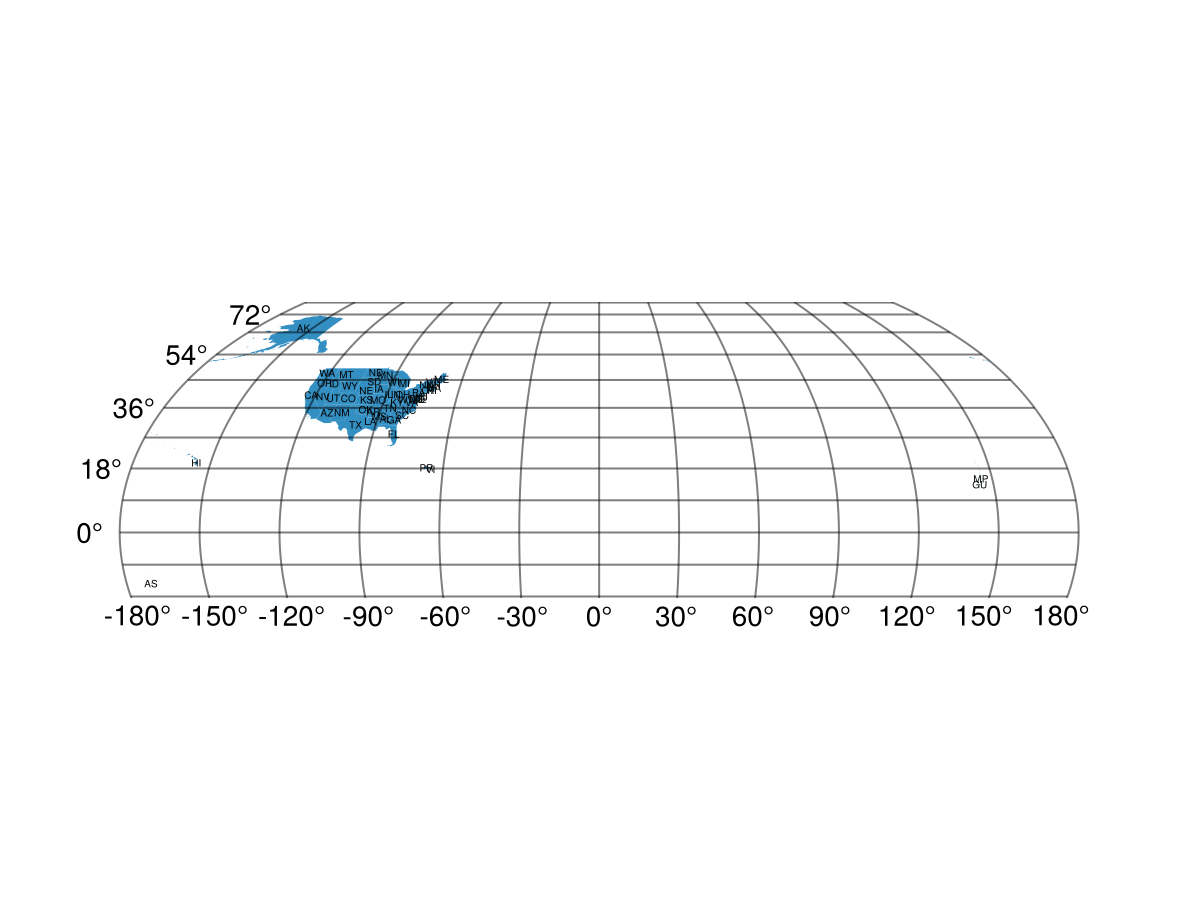

In [29]:
f, a, p = poly(state_census_data.geometry; axis = (; type = GeoAxis))
tp = Makie.text!(a, Polylabel.polylabel.(state_census_data.geometry); text = string.(state_census_data.STUSPS), align = (:center, :center))
tp.fontsize = 5
f

In [ ]:
# save f to a file
#save("census_map.png", f)